In [144]:
import os
if len(os.getcwd().split('/')) != 8:
    os.chdir('..')

print(os.getcwd())

/


In [145]:
# Control Variables
batch_size = 64
lr = 0.01

In [146]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from copy import deepcopy
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Utilities

### Helper Methods

In [147]:
def get_batch_by_idx(train_loader, batch_idx):
    # Calculate start and end indices for the batch
    start_idx = batch_idx * train_loader.batch_size
    end_idx = start_idx + train_loader.batch_size
    
    if end_idx > len(train_loader.dataset):
        end_idx = len(train_loader.dataset)

    # Fetch the data and target tensors for that batch
    data_list, target_list = [], []
    for idx in range(start_idx, end_idx):
        data, target = train_loader.dataset[idx]
        data_list.append(data)
        target_list.append(target)
        
    if data_list:
        # Stack the list into a batch
        data_batch = torch.stack(data_list)
        target_batch = torch.tensor(target_list)

        return data_batch, target_batch
    else:
        return torch.tensor([]), torch.tensor([])

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    y, y_hat = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            y.extend(target.cpu().numpy())
            y_hat.extend(pred.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {avg_test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')

    return avg_test_loss, accuracy, y, y_hat

def train(model, train_loader, optimizer, criterion, batch_idx, device):
    model.to(device)
    model.train()
    train_loss = 0
    
    data, target = get_batch_by_idx(train_loader, batch_idx)
    if data.numel() != 0:
        # current weights
        w_t = {name: weights.clone().detach().to(device) for name, weights in model.state_dict().items()}

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # new weights
        w_t_plus_1 = {name: weights.clone().detach().to(device) for name, weights in model.state_dict().items()}
        updates = {
            name: (w_t[name] - w_t_plus_1[name])
            for name in w_t_plus_1}

        return updates, loss
    else:
        zero_updates = {key: torch.zeros_like(value).to(device) for key, value in model.state_dict().items()}
        zero_loss = 0
        return zero_updates, zero_loss
    
def aggregate_params(global_params, client_updates, client_weights):
    new_global_params = deepcopy(global_params)
    sum_of_updates = {key: torch.zeros_like(value) for key, value in global_params.items()}
    
    for i,updates in enumerate(client_updates):
        for key in updates.keys():
            if key in sum_of_updates:
                sum_of_updates[key] += (updates[key] * client_weights[i])
                
    for key in new_global_params.keys():
        new_global_params[key] -= sum_of_updates[key]

    return new_global_params

### Classes

In [148]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # layer 1
        x = self.conv1(x)
        x = torch.tanh(x) 
        # layer 2
        x = nn.functional.avg_pool2d(input=x, kernel_size=2, stride=2)
        x = torch.tanh(x) 
        # layer 3
        x = self.conv2(x)
        x = torch.tanh(x) 
        # layer 4
        x = nn.functional.avg_pool2d(input=x, kernel_size=2, stride=2)
        x = torch.tanh(x) 
        # layer 5
        x = self.conv3(x)
        x = torch.tanh(x) 
        # layer 6
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = torch.tanh(x) 
        # output layer
        x = self.fc2(x)
        # x = nn.functional.softmax(x, dim=1)  # remove softmax if using crossEntropy since it applies the softmax function too
    
        return x


In [149]:
class Client:
    def __init__(self, model, optimizer, criterion, dataloader):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.dataloader = dataloader

## MNIST Experiment

### Download datasets

In [150]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 as required by LeNet-5
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
print(f"Datasets:\n\t-> TRAIN: {'available' if train_dataset else 'N/A'}\n\t-> TEST: {'available' if train_dataset else 'N/A'}")

Datasets:
	-> TRAIN: available
	-> TEST: available


In [151]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

print(f"Datasets:\n\t-> TRAIN: {len(train_loader.dataset)} samples\n\t-> TEST: {len(test_loader.dataset)} samples")

Datasets:
	-> TRAIN: 60000 samples
	-> TEST: 10000 samples


### Create Clients

In [152]:
all_labels = list(range(0, 10))
client_1_labels = list(range(1, 4))
client_2_labels = list(range(8, 10))
client_3_labels = [x for x in all_labels if x not in client_1_labels + client_2_labels]

client_1_labels, client_2_labels, client_3_labels

([1, 2, 3], [8, 9], [0, 4, 5, 6, 7])

In [153]:
client_1_indices, client_2_indices, client_3_indices = [], [], []

for i, (data, target) in enumerate(train_dataset):
    if target in client_1_labels:
        client_1_indices.append(i)
    elif target in client_2_labels:
        client_2_indices.append(i)
    else:
        client_3_indices.append(i)

client_1_train_loader = DataLoader(Subset(train_dataset, client_1_indices), batch_size=batch_size, shuffle=True)
client_2_train_loader = DataLoader(Subset(train_dataset, client_2_indices), batch_size=batch_size, shuffle=True)
client_3_train_loader = DataLoader(Subset(train_dataset, client_3_indices), batch_size=batch_size, shuffle=True)

client_1_weight = len(client_1_indices)/len(train_dataset)
client_2_weight = len(client_2_indices)/len(train_dataset)
client_3_weight = len(client_3_indices)/len(train_dataset)

client_1_batches = len(client_1_indices)/batch_size
client_2_batches = len(client_2_indices)/batch_size
client_3_batches = len(client_3_indices)/batch_size

print(f'Client 1 indices:{len(client_1_indices)}, Weight: {client_1_weight}, Batches: {client_1_batches}')
print(f'Client 2 indices:{len(client_2_indices)}, Weight: {client_2_weight}, Batches: {client_2_batches}')
print(f'Client 2 indices:{len(client_3_indices)}, Weight: {client_3_weight}, Batches: {client_3_batches}')

Client 1 indices:18831, Weight: 0.31385, Batches: 294.234375
Client 2 indices:11800, Weight: 0.19666666666666666, Batches: 184.375
Client 2 indices:29369, Weight: 0.4894833333333333, Batches: 458.890625


In [154]:
model = LeNet5()
optimizer = optim.Adam(model.parameters(), lr=lr)
client_1 = Client(model=model, 
                  optimizer=optimizer, 
                  criterion=nn.CrossEntropyLoss(), 
                  dataloader=client_1_train_loader)
len(client_1.dataloader.dataset)

18831

In [155]:
model_2 = LeNet5()
optimizer_2 = optim.Adam(model_2.parameters(), lr=lr)
client_2 = Client(model=model_2, 
                  optimizer=optimizer_2, 
                  criterion=nn.CrossEntropyLoss(), 
                  dataloader=client_2_train_loader)
len(client_2.dataloader.dataset)

11800

In [156]:
model_3 = LeNet5()
optimizer_3 = optim.Adam(model_3.parameters(), lr=lr)
client_3 = Client(model=model_3, 
                  optimizer=optimizer_3, 
                  criterion=nn.CrossEntropyLoss(), 
                  dataloader=client_3_train_loader)
len(client_3.dataloader.dataset)

29369

In [157]:
model_0 = LeNet5()
optimizer_0 = optim.Adam(model_2.parameters(), lr=lr)

server = Client(model=model_0, 
                  optimizer=optimizer_0, 
                  criterion=nn.CrossEntropyLoss(), 
                  dataloader=test_loader)
len(server.dataloader.dataset)

10000

### Training Loop

In [158]:
client_weights= [client_1_weight, client_2_weight, client_3_weight]
client_weights

[0.31385, 0.19666666666666666, 0.4894833333333333]

In [159]:
class EarlyStopping:
    def __init__(self, patience=5, target_accuracy=0.90):
        """
        Args:
            patience (int): Number of epochs to wait for improvement before stopping.
            target_accuracy (float): Accuracy target to stop training.
        """
        self.patience = patience
        self.target_accuracy = target_accuracy
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, accuracy):
        if accuracy >= self.target_accuracy:
            self.early_stop = True
        elif val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [160]:
global_model = server.model
global_model.to(device)

early_stopping = EarlyStopping(patience=rounds+1)

test_avg_test_loss, test_accuracy, test_y, test_y_hat = [], [], [], []
for r in range(1, rounds+1):
    print(f'running round:{r}/{rounds+1}')
    # client_1   
    global_params = deepcopy(global_model.state_dict())
    client_1.model.load_state_dict(global_params)
    client_1_updates, client_1_loss = train(model=client_1.model,
                                            train_loader=client_1.dataloader,
                                            optimizer=client_1.optimizer, 
                                            criterion=client_1.criterion, 
                                            batch_idx=r - 1,
                                            device=device)
    
    
    # client_2
    global_params = deepcopy(global_model.state_dict())
    client_2.model.load_state_dict(global_params)
    client_2_updates, client_2_loss = train(model=client_2.model,
                                            train_loader=client_2.dataloader,
                                            optimizer=client_2.optimizer, 
                                            criterion=client_2.criterion, 
                                            batch_idx=r - 1,
                                            device=device)
    
    # client_3
    global_params = deepcopy(global_model.state_dict())
    client_3.model.load_state_dict(global_params)
    client_3_updates, client_3_loss = train(model=client_3.model,
                                            train_loader=client_3.dataloader,
                                            optimizer=client_3.optimizer, 
                                            criterion=client_3.criterion, 
                                            batch_idx=r - 1,
                                            device=device)
    
    new_global_params = aggregate_params(global_params=global_model.state_dict(), 
                                         client_updates=[client_1_updates, client_2_updates, client_3_updates], 
                                         client_weights=client_weights)
    
    
    global_model.load_state_dict(new_global_params)
    
    
    avg_test_loss, accuracy, y, y_hat = test(model=global_model, 
                                             device=device, 
                                             test_loader=server.dataloader, 
                                             criterion=server.criterion)
    test_avg_test_loss.append(avg_test_loss) 
    test_accuracy.append(accuracy)
    
    # Check for early stopping
    early_stopping(avg_test_loss, accuracy/100)
    if early_stopping.early_stop:
        print(f'Early stopping at round {r}')
        break

running round:1/295

Test set: Average loss: 0.0022, Accuracy: 4052/10000 (41%)

running round:2/295

Test set: Average loss: 0.0020, Accuracy: 5292/10000 (53%)

running round:3/295

Test set: Average loss: 0.0017, Accuracy: 5715/10000 (57%)

running round:4/295

Test set: Average loss: 0.0015, Accuracy: 5829/10000 (58%)

running round:5/295

Test set: Average loss: 0.0014, Accuracy: 6000/10000 (60%)

running round:6/295

Test set: Average loss: 0.0013, Accuracy: 6263/10000 (63%)

running round:7/295

Test set: Average loss: 0.0012, Accuracy: 6399/10000 (64%)

running round:8/295

Test set: Average loss: 0.0012, Accuracy: 6454/10000 (65%)

running round:9/295

Test set: Average loss: 0.0011, Accuracy: 6451/10000 (65%)

running round:10/295

Test set: Average loss: 0.0011, Accuracy: 6631/10000 (66%)

running round:11/295

Test set: Average loss: 0.0011, Accuracy: 6772/10000 (68%)

running round:12/295

Test set: Average loss: 0.0010, Accuracy: 6923/10000 (69%)

running round:13/295

Tes

In [164]:
df = pd.DataFrame({
    'Round': range(1, len(test_accuracy) + 1),
    'Accuracy': test_accuracy
})

df

,Round,Accuracy
0,1,40.52
1,2,52.92
2,3,57.15
3,4,58.29
4,5,60.00
...,...,...
69,70,84.64
70,71,84.70
71,72,85.60
72,73,88.85


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


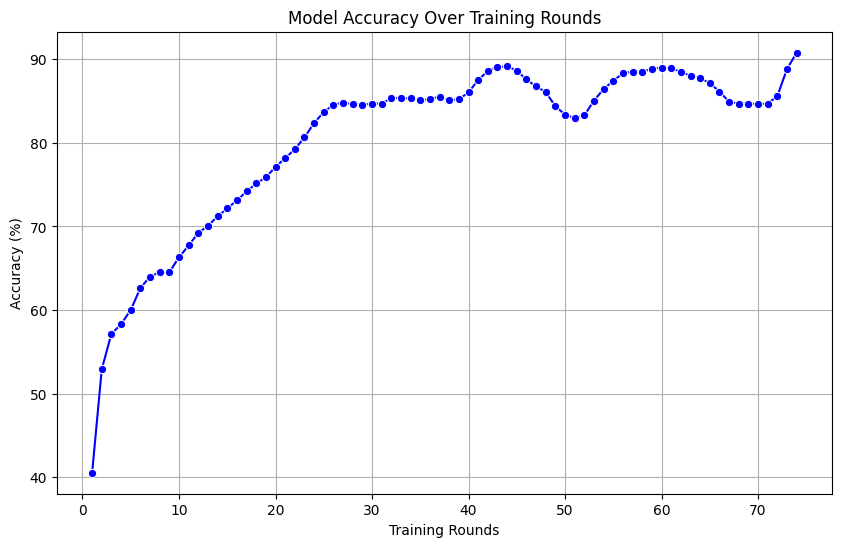

In [165]:
# Plot accuracy using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Round', y='Accuracy', marker='o', color='b')
plt.title('Model Accuracy Over Training Rounds')
plt.xlabel('Training Rounds')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()